## MSCA 31013 - Big Data Platforms - Course Project

### B2B: Iowa Liquor Sales : Modelling
### Submitted by:

#saurabhs
#dmcdonough
#dtallarico90

@uchicago.edu

## 3. Build models 

### 3.1 Load data
#### NOTE: Lines have been commented since files have been downloadded on HDFS.

Move clean file to HDFS

In [2]:
#! hdfs dfs -put -f LiqourSales_Forecast.csv /user/saurabhs/BigData/Project

In [3]:
#! hdfs dfs -ls /user/saurabhs/BigData/Project

Java HotSpot(TM) 64-Bit Server VM warning: ignoring option MaxPermSize=512M; support was removed in 8.0
Found 7 items
-rw-r--r--   3 saurabhs saurabhs     853875 2019-03-11 16:43 /user/saurabhs/BigData/Project/Forecast_NoCat.csv
-rw-r--r--   3 saurabhs saurabhs    5090776 2019-03-11 16:37 /user/saurabhs/BigData/Project/Forecast_WithCat.csv
-rw-r--r--   3 saurabhs saurabhs 4269077843 2019-03-07 09:49 /user/saurabhs/BigData/Project/Iowa_Liquor_Sales-clean.csv
-rw-r--r--   3 saurabhs saurabhs     271756 2019-03-07 09:50 /user/saurabhs/BigData/Project/Iowa_Liquor_Stores.csv
-rw-r--r--   3 saurabhs saurabhs      14865 2019-03-12 11:09 /user/saurabhs/BigData/Project/Iowa_Population.csv
-rw-r--r--   3 saurabhs saurabhs    1504312 2019-03-12 12:11 /user/saurabhs/BigData/Project/LiqourSales_Forecast.csv
-rw-r--r--   3 saurabhs saurabhs       2898 2019-03-12 11:09 /user/saurabhs/BigData/Project/catmap.csv


Import the necessary packages and load the data.

In [1]:
# Python packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
import datetime

#PySpark SQL packages
from pyspark.sql import SparkSession
from pyspark.sql import HiveContext
from pyspark.sql import functions as F
from pyspark.sql.functions import upper, col
from pyspark.sql import SQLContext

# PySpark pipeline and feature packages
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator
from pyspark.ml.feature import StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

# PySpark ML Algorithms for regression
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import GBTRegressor

# Supress pandas or other warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### 3.2 Instantiate sparksession object by checking if this notebook is running locally or on RCC. Load spark dataframe and check schema

In [2]:
from notebook import notebookapp
servers = list(notebookapp.list_running_servers())

# Check if running local or on RCC
if (servers[0]['hostname'] == "localhost"):
    IsRCC = False
else:
    IsRCC = True

Load context objects

In [3]:
if (IsRCC):
    spark = SparkSession.builder.appName('ProjectLiquor').getOrCreate()
    sqlContext = SQLContext(sc) # RCC spark context
else:
    #create Spark session locally
    spark = SparkSession.builder.appName('ProjectLiquor_local').getOrCreate()

    #change configuration settings on Spark 
    conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '5g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','8g')])
    sc = spark.sparkContext # Local spark context
    sqlContext = SQLContext(sc)

Confirm configuration of spark driver

In [4]:
#print spark configuration settings
spark.sparkContext.getConf().getAll()

[('spark.executor.id', 'driver'),
 ('spark.executor.memory', '5g'),
 ('spark.app.id', 'local-1552519180556'),
 ('spark.executor.cores', '4'),
 ('spark.cores.max', '4'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.memory', '8g'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.driver.host', 'INFERNO-PC'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.port', '53048'),
 ('spark.app.name', 'ProjectLiquor_local'),
 ('spark.ui.showConsoleProgress', 'true')]

Load file path accordingly in case of RCC vs Local

In [5]:
if (IsRCC): 
    # Update to RCC file names
    Forecast_File = '/user/saurabhs/BigData/Project/LiqourSales_Forecast.csv'
else:
    #Update to local file names
    Forecast_File = 'LiqourSales_Forecast.csv'

#### Load the file into PySpark dataframe for downstream processing

In [6]:
%%time
  
df = (spark.read
.option("header", "true")
.option("inferSchema", "true")
.option("multiLine", "true")
.option("delimiter", ",")
.format("csv")
.load(Forecast_File))

Wall time: 1.75 s


In [7]:
#Impute empty values
df = df.fillna(0)
df = df.replace([np.inf, -np.inf],0)
df = df.na.fill('UNKNOWN')

In [8]:
df.select([F.count(F.when(F.isnan(c)| F.col(c).isNull() , c)).alias(c) for c in df.columns]).show()

+------------+--------+------------------+---------------+------+-----------+------------+------------+------------+------------+----+-------+---+-----+---+-------+-----+-------+
|Store Number|saleyear|Yearly_Total_Sales|Last_Year_Sales|Markup|Tenure_days|Q1_QoQ_Sales|Q2_QoQ_Sales|Q3_QoQ_Sales|Q4_QoQ_Sales|City|CityPop|Gin|Other|Rum|Tequila|Vodka|Whiskey|
+------------+--------+------------------+---------------+------+-----------+------------+------------+------------+------------+----+-------+---+-----+---+-------+-----+-------+
|           0|       0|                 0|              0|     0|          0|           0|           0|           0|           0|   0|      0|  0|    0|  0|      0|    0|      0|
+------------+--------+------------------+---------------+------+-----------+------------+------------+------------+------------+----+-------+---+-----+---+-------+-----+-------+



In [9]:
pdf_summary = df.toPandas()

In [10]:
df.show(10)

+------------+--------+------------------+------------------+-------------------+-----------+--------------------+--------------------+--------------------+--------------------+-----------+-------+--------------------+-------------------+-------------------+--------------------+-------------------+-------------------+
|Store Number|saleyear|Yearly_Total_Sales|   Last_Year_Sales|             Markup|Tenure_days|        Q1_QoQ_Sales|        Q2_QoQ_Sales|        Q3_QoQ_Sales|        Q4_QoQ_Sales|       City|CityPop|                 Gin|              Other|                Rum|             Tequila|              Vodka|            Whiskey|
+------------+--------+------------------+------------------+-------------------+-----------+--------------------+--------------------+--------------------+--------------------+-----------+-------+--------------------+-------------------+-------------------+--------------------+-------------------+-------------------+
|        2106|    2015|         172518.4

In [11]:
df.dtypes

[('Store Number', 'int'),
 ('saleyear', 'int'),
 ('Yearly_Total_Sales', 'double'),
 ('Last_Year_Sales', 'double'),
 ('Markup', 'double'),
 ('Tenure_days', 'int'),
 ('Q1_QoQ_Sales', 'double'),
 ('Q2_QoQ_Sales', 'double'),
 ('Q3_QoQ_Sales', 'double'),
 ('Q4_QoQ_Sales', 'double'),
 ('City', 'string'),
 ('CityPop', 'double'),
 ('Gin', 'double'),
 ('Other', 'double'),
 ('Rum', 'double'),
 ('Tequila', 'double'),
 ('Vodka', 'double'),
 ('Whiskey', 'double')]

### 3.3 Find correlation between independent variables and target variable.

In [12]:
%%time

corrmat = []
import six #To support python 2 and 3 string types
for i in df.columns:
    if not( isinstance(df.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to Yearly_Total_Sales for ", i, df.stat.corr('Yearly_Total_Sales',i))
        corrmat.append(df.stat.corr('Yearly_Total_Sales',i))

Correlation to Yearly_Total_Sales for  Store Number -0.32542389638366925
Correlation to Yearly_Total_Sales for  saleyear 0.02637378579124009
Correlation to Yearly_Total_Sales for  Yearly_Total_Sales 1.0
Correlation to Yearly_Total_Sales for  Last_Year_Sales 0.9788880744173075
Correlation to Yearly_Total_Sales for  Markup -0.018880843378605676
Correlation to Yearly_Total_Sales for  Tenure_days 0.1448630020538163
Correlation to Yearly_Total_Sales for  Q1_QoQ_Sales -0.005052598423663561
Correlation to Yearly_Total_Sales for  Q2_QoQ_Sales -0.02399277899871876
Correlation to Yearly_Total_Sales for  Q3_QoQ_Sales -0.02149776011982918
Correlation to Yearly_Total_Sales for  Q4_QoQ_Sales -0.010391932191338217
Correlation to Yearly_Total_Sales for  CityPop 0.16912479207621836
Correlation to Yearly_Total_Sales for  Gin 0.1377156142105007
Correlation to Yearly_Total_Sales for  Other 0.09378059500034237
Correlation to Yearly_Total_Sales for  Rum -0.06238642997819047
Correlation to Yearly_Total_Sales

<Figure size 1440x1440 with 0 Axes>

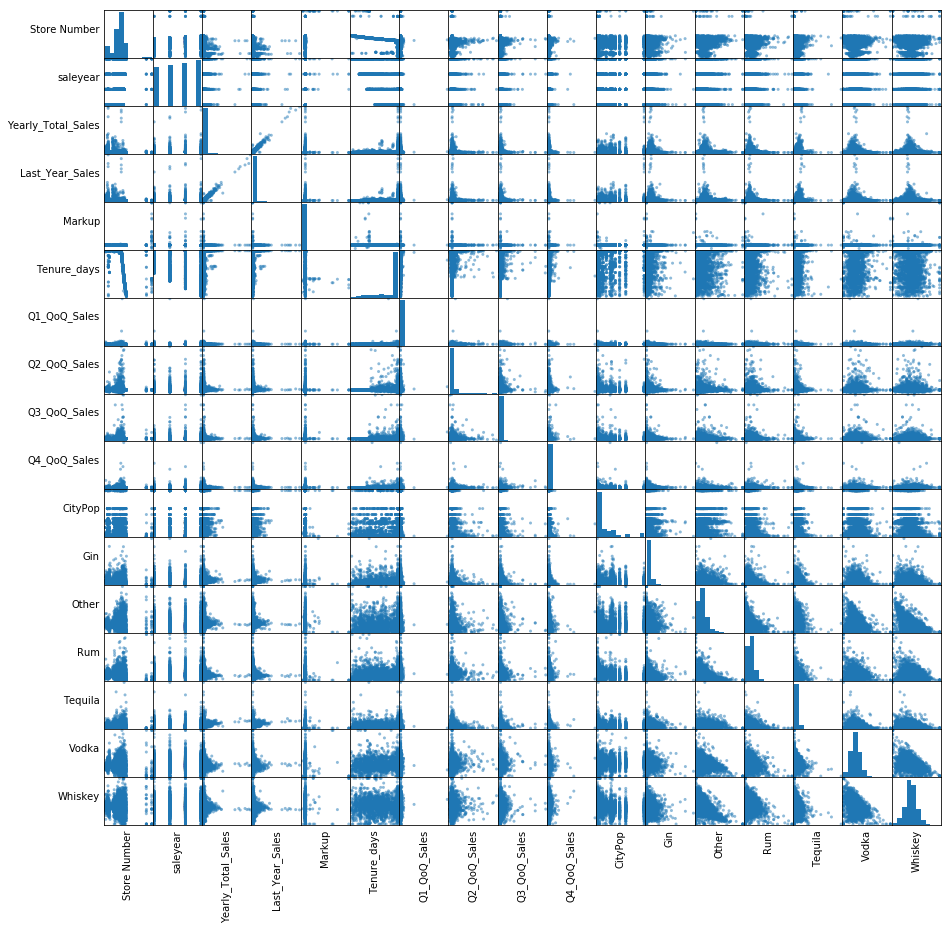

In [13]:
plt.figure(figsize=(20,20))

numeric_features = [t[0] for t in df.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = df.select(numeric_features).sample(False, 0.8).toPandas()
sampled_data.drop("Yearly_Total_Sales", axis=1)
axs = pd.plotting.scatter_matrix(sampled_data, figsize=(15, 15))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

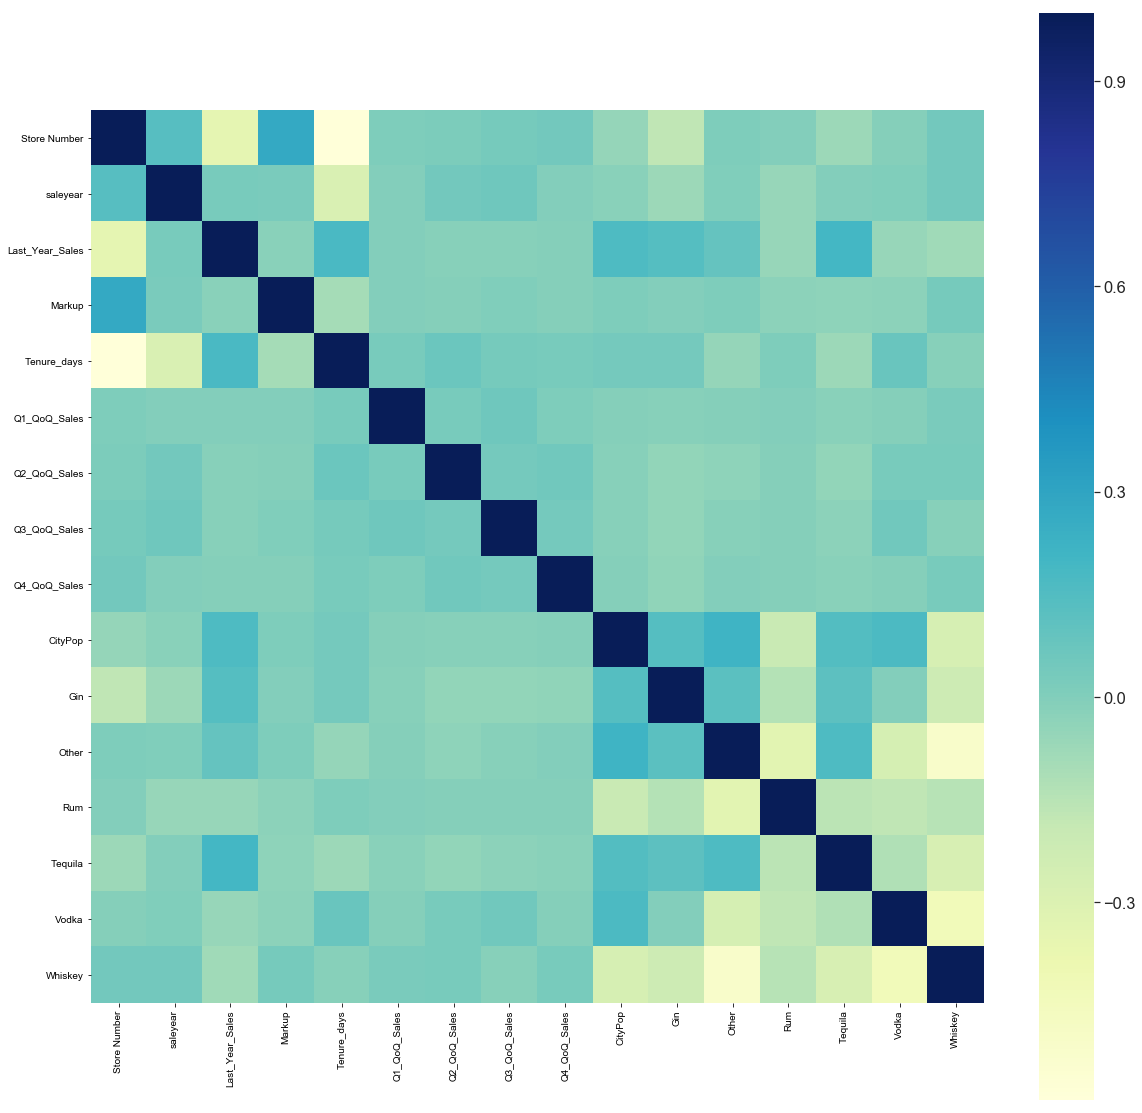

In [14]:
# Correlation heatmap
fig, ax = plt.subplots(figsize=(20,20))     
sns.set(font_scale=1.5) 
ax = sns.heatmap(pdf_summary.drop("Yearly_Total_Sales", axis=1).corr(), square=True, cbar_kws={"orientation": "vertical"}, \
                 fmt="d", cmap="YlGnBu")
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
plt.show()

### 3.4 Build pipeline for feature engineering

In [15]:
# Check schema
df.printSchema()

root
 |-- Store Number: integer (nullable = true)
 |-- saleyear: integer (nullable = true)
 |-- Yearly_Total_Sales: double (nullable = false)
 |-- Last_Year_Sales: double (nullable = false)
 |-- Markup: double (nullable = false)
 |-- Tenure_days: integer (nullable = true)
 |-- Q1_QoQ_Sales: double (nullable = false)
 |-- Q2_QoQ_Sales: double (nullable = false)
 |-- Q3_QoQ_Sales: double (nullable = false)
 |-- Q4_QoQ_Sales: double (nullable = false)
 |-- City: string (nullable = false)
 |-- CityPop: double (nullable = false)
 |-- Gin: double (nullable = false)
 |-- Other: double (nullable = false)
 |-- Rum: double (nullable = false)
 |-- Tequila: double (nullable = false)
 |-- Vodka: double (nullable = false)
 |-- Whiskey: double (nullable = false)



#### Create StringIndexer and OneHotEncoder components for processing.

In [12]:
# convert relevant categorical into one hot encoded
indexer1 = StringIndexer(inputCol="City", outputCol="cityIdx").setHandleInvalid("skip")

# Gather all indexers as inputs to the One Hot Encoder
inputs = [indexer1.getOutputCol()]

# #create the one hot encoder
OHEncoder = OneHotEncoderEstimator(inputCols=inputs,  \
                                  outputCols=["cityVec"])

#run it through a pipeline
pipeline = Pipeline(stages=[indexer1, OHEncoder])
encodedData = pipeline.fit(df).transform(df)

In [13]:
#Check datatypes and select final features
encodedData.printSchema()

root
 |-- Store Number: integer (nullable = true)
 |-- saleyear: integer (nullable = true)
 |-- Yearly_Total_Sales: double (nullable = false)
 |-- Last_Year_Sales: double (nullable = false)
 |-- Markup: double (nullable = false)
 |-- Tenure_days: integer (nullable = true)
 |-- Q1_QoQ_Sales: double (nullable = false)
 |-- Q2_QoQ_Sales: double (nullable = false)
 |-- Q3_QoQ_Sales: double (nullable = false)
 |-- Q4_QoQ_Sales: double (nullable = false)
 |-- City: string (nullable = false)
 |-- CityPop: double (nullable = false)
 |-- Gin: double (nullable = false)
 |-- Other: double (nullable = false)
 |-- Rum: double (nullable = false)
 |-- Tequila: double (nullable = false)
 |-- Vodka: double (nullable = false)
 |-- Whiskey: double (nullable = false)
 |-- cityIdx: double (nullable = false)
 |-- cityVec: vector (nullable = true)



Select numeric variables and vectors as features

In [14]:
#final_features = ['Store Number',  'saleyear',  'Last_Year_Sales',\
final_features = [ 'saleyear',  'Last_Year_Sales',\
                    'Markup',  'Tenure_days',  'Q1_QoQ_Sales',  'Q2_QoQ_Sales',\
                  'Q3_QoQ_Sales', 'Q4_QoQ_Sales', 'CityPop',  \
                  'Gin',  'Other',  'Rum',  'Tequila',  'Vodka',  'Whiskey', 'cityVec']

#### Use VectorAssembler and Scaler in pipeline

In [15]:
vectorAssembler = VectorAssembler(inputCols = final_features, outputCol = 'features')

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

# #run it through a pipeline
pipeline = Pipeline(stages=[vectorAssembler, scaler])
v_df = pipeline.fit(encodedData).transform(encodedData)

In [16]:
vDF = v_df.selectExpr("scaledFeatures as features", "Yearly_Total_Sales as label" )

In [17]:
vDF.toPandas().head()

,features,label
0,"(1814.1470313988916, 2.194790956723736, 0.9262...",172518.49
1,"(1815.0473525062855, 2.432303089913116, 0.9190...",175869.29
2,"(1815.9476736136796, 2.479545337359642, 0.9173...",209448.04
3,"(1816.8479947210735, 2.952965301680104, 0.9216...",216470.00
4,"(1814.1470313988916, 0.1956439240200395, 0.927...",12261.90


#### Completed vector transformation of all input features

### 3.5 Run models on transformed dataframe

In [18]:
# Split the data into training and test sets (30% held out for testing)
(train_df, test_df) = vDF.randomSplit([0.7, 0.3])

evaluatorR2 = RegressionEvaluator(predictionCol="prediction",labelCol="label",metricName="r2")
evaluatorRMSE = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

In [20]:
# Function to plot predicted vs measured 
def plotPredictedActual(df, mytitle="Regression"):
    pdf = df.select("prediction","label","features").toPandas()
    y = pdf.label
    predicted = pdf.prediction

    fig,ax = plt.subplots()
    ax.scatter(y, predicted)
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    ax.set_title(mytitle)
    fig.show()

### 3.5.1 Model 1 - Linear Regression

R Squared (R2) on training data: 0.964541
Root Mean Squared Error (RMSE) on training data: 16113.719822
+------------------+------------------+--------------------+
|        prediction|             label|            features|
+------------------+------------------+--------------------+
| 8488.048868276877|           8228.43|(436,[0,1,2,3,4,5...|
| 9844.261798966909| 8479.650000000001|(436,[0,1,2,3,4,5...|
|13602.223017615266|           8698.01|(436,[0,1,2,3,4,5...|
|14525.672087460523|           8962.46|(436,[0,1,2,3,4,5...|
| 16889.80041249981|15479.820000000002|(436,[0,1,2,3,4,5...|
+------------------+------------------+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.941377
Root Mean Squared Error (RMSE) on test data = 13185.3


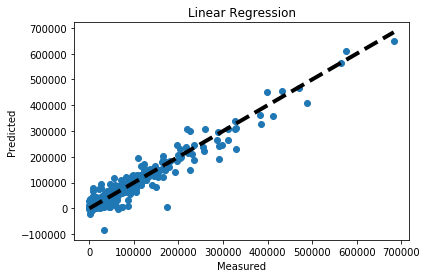

In [29]:
lr = LinearRegression(featuresCol = 'features', labelCol='label', maxIter=50)

lr_model = lr.fit(train_df)

trainingSummary = lr_model.summary

lr_predictions = lr_model.transform(test_df)

print("R Squared (R2) on training data: %f" % trainingSummary.r2)
print("Root Mean Squared Error (RMSE) on training data: %f" % trainingSummary.rootMeanSquaredError)

lr_predictions.select("prediction","label","features").show(5)

# Select (prediction, true label) and compute test error
print("R Squared (R2) on test data = %g" % evaluatorR2.evaluate(lr_predictions))
print("Root Mean Squared Error (RMSE) on test data = %g" % evaluatorRMSE.evaluate(lr_predictions))

plotPredictedActual(lr_predictions, "Linear Regression")

### 3.5.2 Model 2 - DT Regression

+------------------+------------------+--------------------+
|        prediction|             label|            features|
+------------------+------------------+--------------------+
| 6290.617783018865|           8228.43|(436,[0,1,2,3,4,5...|
|  9355.90097777778| 8479.650000000001|(436,[0,1,2,3,4,5...|
|12119.931054852319|           8698.01|(436,[0,1,2,3,4,5...|
|12119.931054852319|           8962.46|(436,[0,1,2,3,4,5...|
|14205.245158730157|15479.820000000002|(436,[0,1,2,3,4,5...|
+------------------+------------------+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.782898
Root Mean Squared Error (RMSE) on test data = 25374
DecisionTreeRegressionModel (uid=DecisionTreeRegressor_706f9eee32a6) of depth 10 with 483 nodes


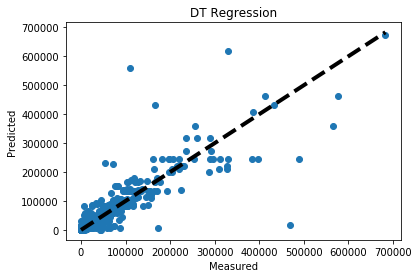

In [27]:
# Train a DecisionTree model.
dt = DecisionTreeRegressor(featuresCol="features", maxDepth=10)

# Train model.  This also runs the indexer.
model = dt.fit(train_df)

# Make predictions.
predictions = model.transform(test_df)

# Select example rows to display.
predictions.select("prediction", "label", "features").show(5)

# Select (prediction, true label) and compute test error
print("R Squared (R2) on test data = %g" % evaluatorR2.evaluate(predictions))
print("Root Mean Squared Error (RMSE) on test data = %g" % evaluatorRMSE.evaluate(predictions))

# summary only
print(model)  

plotPredictedActual(predictions, "DT Regression")

### 3.5.3 Model 3 - RandomForest Regressor

+------------------+------------------+--------------------+
|        prediction|             label|            features|
+------------------+------------------+--------------------+
| 8915.413590685044|           8228.43|(436,[0,1,2,3,4,5...|
| 12277.20433638187| 8479.650000000001|(436,[0,1,2,3,4,5...|
|12139.286214227319|           8698.01|(436,[0,1,2,3,4,5...|
|25262.355168481092|           8962.46|(436,[0,1,2,3,4,5...|
|14668.385772046193|15479.820000000002|(436,[0,1,2,3,4,5...|
+------------------+------------------+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.869161
Root Mean Squared Error (RMSE) on test data = 19698.2
RandomForestRegressionModel (uid=RandomForestRegressor_39fa731f8dc1) with 250 trees
Wall time: 32.5 s


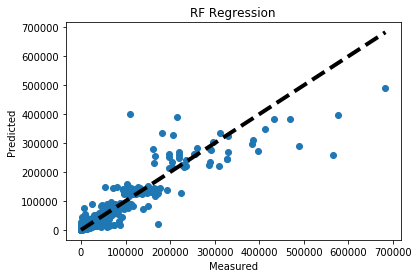

In [26]:
%%time

# Train a RandomForest model.
rf = RandomForestRegressor(featuresCol="features", maxDepth=10, numTrees=250)

# Train model.  This also runs the indexer.
model = rf.fit(train_df)

# Make predictions.
predictions = model.transform(test_df)

# Select example rows to display.
predictions.select("prediction", "label", "features").show(5)

# Select (prediction, true label) and compute test error
print("R Squared (R2) on test data = %g" % evaluatorR2.evaluate(predictions))
print("Root Mean Squared Error (RMSE) on test data = %g" % evaluatorRMSE.evaluate(predictions))

# summary only
print(model)  

plotPredictedActual(predictions, "RF Regression")

### 3.5.4 Model 4 - GBT Regressor

+------------------+------------------+--------------------+
|        prediction|             label|            features|
+------------------+------------------+--------------------+
| 5439.789962815757|           8228.43|(436,[0,1,2,3,4,5...|
|10450.443307531796| 8479.650000000001|(436,[0,1,2,3,4,5...|
|11018.776173528733|           8698.01|(436,[0,1,2,3,4,5...|
|11743.088718377116|           8962.46|(436,[0,1,2,3,4,5...|
|14074.153306434293|15479.820000000002|(436,[0,1,2,3,4,5...|
+------------------+------------------+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.7665
Root Mean Squared Error (RMSE) on test data = 26314.8
GBTRegressionModel (uid=GBTRegressor_b0f8d2c8753f) with 50 trees


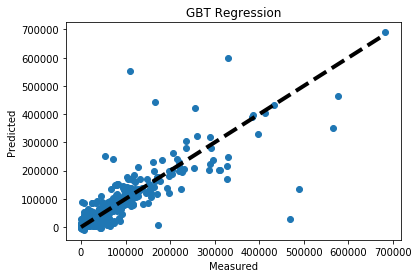

In [28]:
# Train a GBT model.
gbt = GBTRegressor(featuresCol="features", maxIter=50, maxDepth=10)

# Train model.  This also runs the indexer.
model = gbt.fit(train_df)

# Make predictions.
predictions = model.transform(test_df)

# Select example rows to display.
predictions.select("prediction", "label", "features").show(5)

# Select (prediction, true label) and compute test error
print("R Squared (R2) on test data = %g" % evaluatorR2.evaluate(predictions))
print("Root Mean Squared Error (RMSE) on test data = %g" % evaluatorRMSE.evaluate(predictions))

# Summary only
print(model)  

plotPredictedActual(predictions, "GBT Regression")

### Exploratory Graphs

In [1]:
import pandas as pd
import matplotlib as plt
import seaborn as sns

In [2]:
By_Quart = pd.read_csv('PriorYearSalesAnnualizedQtr.csv')
Prior = pd.read_csv('PriorYearSales.csv')
Quarterly = pd.read_csv('QuarterlySalesFigures.csv')
CityStores = pd.read_csv('CityStores.csv')
Tenure = pd.read_csv('TenureOfStores.csv')
Profit_Margin = pd.read_csv('AverageProfitMarginByStore.csv')

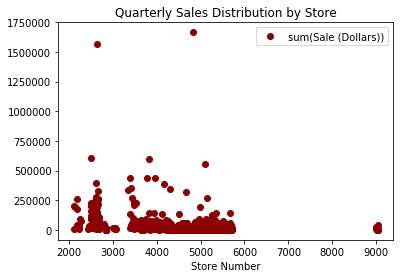

In [81]:
Quarterly.plot(x='Store Number', y='sum(Sale (Dollars))', style='o',c = 'darkred',title="Quarterly Sales Distribution by Store")

In [4]:
#Adding in Population Data
Population = pd.read_csv('Iowa_Population.csv')

In [5]:
#Combining Tables
Double = pd.merge(CityStores,Population,on='City')
Triple = pd.merge(Prior,Double,on='Store Number')

In [6]:
Triple["Population"] = pd.to_numeric(Triple["Population"])

In [7]:
x = Triple.groupby('City').sum()
x = x.drop(['saleyear','Store Number','Population'],axis=1)
x=x.sort_values('sum(Sale (Dollars))', ascending=False)
y = x[1:25]

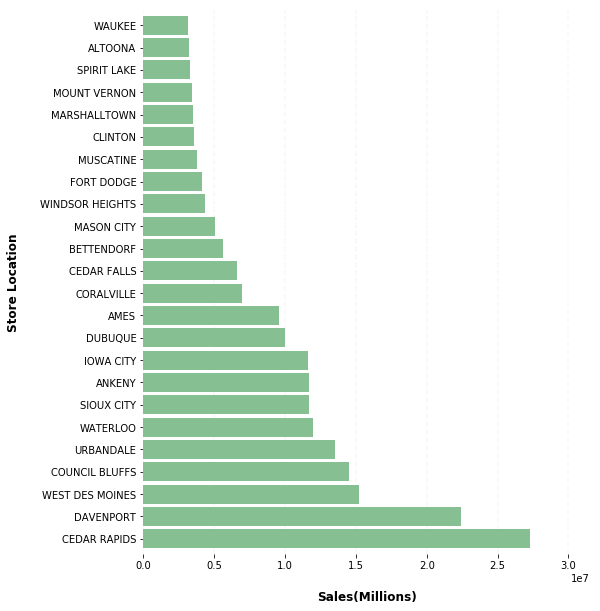

In [9]:
#Graphing City Sales
ax = y.plot(kind='barh', figsize=(8, 10), color='#86bf91', zorder=2, width=0.85)

  # Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

  # Switch off ticks
ax.tick_params(axis=True, which=True, bottom=False, top=False, labelbottom=True, left=False, right=False, labelleft=True)

  # Draw vertical axis lines
vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

  # Set x-axis label
ax.set_xlabel("Sales(Millions)", labelpad=20, weight='bold', size=12)

  # Set y-axis label
ax.set_ylabel("Store Location", labelpad=20, weight='bold', size=12)
ax.get_legend().remove()

In [10]:
#Getting Population Correlation For Powerpoint
Triple = Triple.set_index('Store Number')
Correl = Triple.drop(['Store Name_x','saleyear','Store Name_y','City'],axis=1)
#interesting to note virtually no correlation between size of city and sales
correlation = Triple['Population'].corr(Triple['sum(Sale (Dollars))'])
correlation

0.16654202936169588

Text(0.5,1,'Store Sales by Population Scattered')

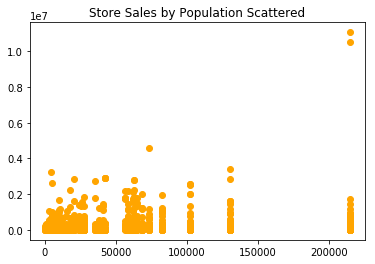

In [78]:
#Population vs Sales
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

plt.scatter(Triple['Population'], Triple['sum(Sale (Dollars))'],c='orange')
plt.ticklabel_format(useOffset=False)
plt.title('Store Sales by Population Scattered')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


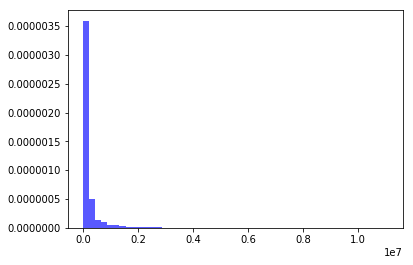

In [24]:
#Sales Histogram
num_bins = 50
plt.hist(Prior['sum(Sale (Dollars))'], num_bins, normed=4, facecolor='blue', alpha=.65)
plt.ticklabel_format(useOffset=True)
plt.show()

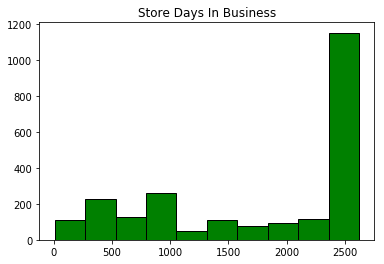

In [22]:
#Days in Business
plt.hist(Tenure['days_in_business'],edgecolor='black', facecolor='green')

plt.title('Store Days In Business')
plt.savefig('Days In Business.png')

In [15]:
Forecast = pd.read_csv('LiqourSales_Forecast.csv')

In [16]:
#Getting the average basket for stores
Basket=Forecast.iloc[:, [12, 13, 14,15,16,17]]
mean_basket = Basket.mean()
mean_basket

Gin        0.017587
Other      0.155684
Rum        0.132798
Tequila    0.037294
Vodka      0.259646
Whiskey    0.394633
dtype: float64

In [17]:
#Seeing Kum and Gos basket(for PowerPoint example)
Basket=Forecast.iloc[:, [0,12, 13, 14,15,16,17]]
KumandGo = Basket[Basket['Store Number']==4457].mean()
KumandGo = KumandGo.drop('Store Number')
KumandGo

Gin        0.057026
Other      0.112060
Rum        0.110860
Tequila    0.032135
Vodka      0.379551
Whiskey    0.308369
dtype: float64

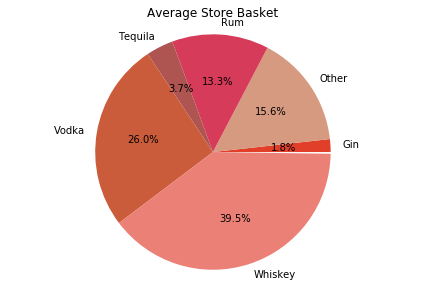

In [18]:
# Plotting the average basket
import matplotlib.pyplot as plt
colors = ["#E13F29", "#D69A80", "#D63B59", "#AE5552", "#CB5C3B", "#EB8076", "#96624E"]

# Create a pie chart
plt.pie(
    # using data total)arrests
    mean_basket,
    labels=('Gin','Other','Rum','Tequila','Vodka','Whiskey'),
    shadow=False,
    colors=colors,
    autopct='%1.1f%%'
    )

# View the plot drop above
plt.axis('equal')

# View the plot
plt.tight_layout()
plt.title('Average Store Basket')
plt.show()

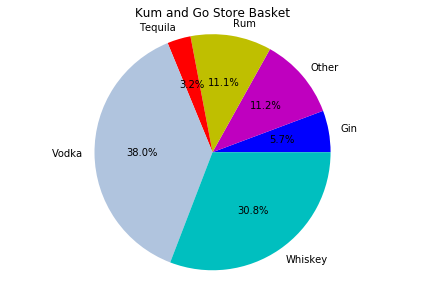

In [19]:
# Plotting the Kum and Go basket, they are behind on Whiskey!
import matplotlib.pyplot as plt
colors = ["b", "m", "y", "r", "lightsteelblue", "c"]

# Create a pie chart
plt.pie(
    # using data total)arrests
    KumandGo,
    labels=('Gin','Other','Rum','Tequila','Vodka','Whiskey'),
    shadow=False,
    colors=colors,
    autopct='%1.1f%%'
    )

# View the plot drop above
plt.axis('equal')

# View the plot
plt.tight_layout()
plt.title('Kum and Go Store Basket')
plt.show()

In [54]:
Double = Double.drop(["Population","Store Name"],axis=1)

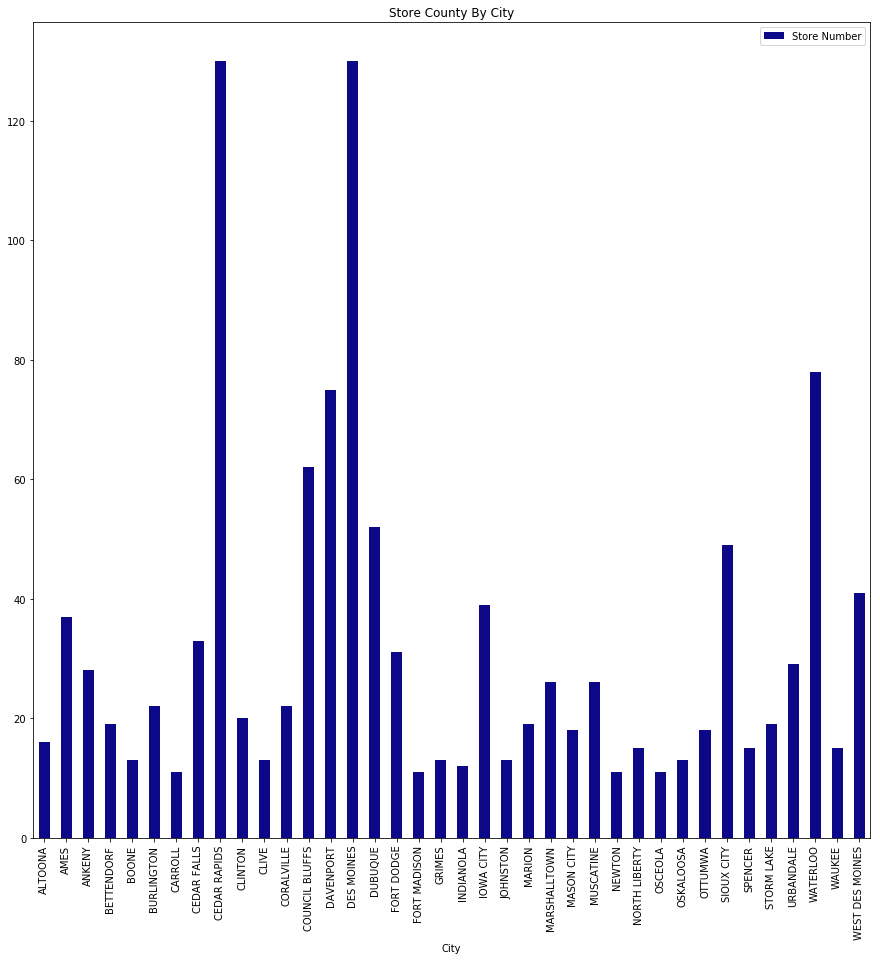

In [74]:
#Count of store by City Name where city has more than 10 stores
group = Double.groupby(["City"]).count()
group = group[group['Store Number']>10]
ax = group.plot(kind="bar",figsize=(15,15),grid=False,colormap='plasma',title='Store County By City')
